In [58]:
# Lots of imports needed
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

In [36]:
# Reading the Data, using a specific sheet name. Starting off by skipping the first 5 rows, because that completely messes up the data.
alb_mbd = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="ALB_MBD", skiprows=5)
pzq = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="PZQ", skiprows=5)
ivm = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="IVM", skiprows=5)
nigeria_lf = pd.read_csv('../Data/Nigeria/data-NG-lf-iu-2017-undefined-2017.csv')
nigeria_lf.loc[nigeria_lf.ADMIN1_NAME == 'Fct, Abuja', 'ADMIN1_NAME'] = 'Federal Capital Territory'
nigeria_lf.loc[nigeria_lf.ADMIN1_NAME == 'Nassarawa', 'ADMIN1_NAME'] = 'Nasarawa'

In [57]:
## printing the top two rows, as these are the unformated columns. I used this to figure out which columns I needed for the data.
#print(data.loc[0])
#print(data.loc[1])
#nigeria_lf.head()
ivm.head()

,Country administrative structure,Unnamed: 1,Unnamed: 2,Population requiring treatment with IVM,Treatment plan,Unnamed: 5,Target population,Unnamed: 7,Unnamed: 8,Unnamed: 9,Ivermectin (IVM),Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,Country,Province/State,District,NaN,LF,Oncho,LF,Oncho,NaN,NaN,LF only,Oncho only,LF+Oncho,Total required,Remaining in stock,Tablets to be procured,Bottles (3mg)\n500 tablets
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in the district,village,total,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nigeria,Abia,Aba North,115648.0,1,2,115648,55037.2,44029.8,44029.8,200531,123283,123283,447098,NaN,447098,895
3,Nigeria,Abia,Aba South,456027.0,1,2,456027,217026,173621,173621,790737,486139,486139,1.76301e+06,NaN,1.76301e+06,3527
4,Nigeria,Abia,Arochukwu,183126.0,1,2,183126,71726.9,57381.5,57381.5,352085,160668,160668,673421,NaN,673421,1347


In [60]:
#IVM LF & Oncho
ivm_total_treatment_lf = ivm.iloc[2:, 6]

# the total treatment for ivm for oncho does not include the values from in the district
ivm_total_treatment
oncho_ivm_total_treatment = ivm.iloc[2:, 9]
lf_ivm_total_treatment = ivm.iloc[2:, 6]
#ivm_total_treatment = ivm_total_treatment_lf + ivm_total_treatment_oncho
lf_ivm_procured = ivm.iloc[2:, 10] + ivm.iloc[2:, 12]
oncho_ivm_procured = ivm.iloc[2:11]

In [61]:
#Schistosoma
pzq_dist_names = pzq.iloc[2:, 2]
pzq_total_treatment = pzq.iloc[2:, 5]
pzq_tab_procured = pzq.iloc[2:, [16, 17]]
schisto_pzq_total_procured = pzq_tab_procured.iloc[:, 0]# + pzq_tab_procured.iloc[:, 1]

In [62]:
# Here I selecte the different colummns I  need and store them as seperate Series. The rows start at level 2
# The columns for the first two variables have names, but the rest I find by indexing.
state_names = alb_mbd.loc[2:, "Unnamed: 1"]
district_names = alb_mbd.loc[2:, "Unnamed: 2"]
alb_mbd_total_treatment = alb_mbd.loc[2:, "Population requiring treatment with ALB/MBD"]
total_target_mbd = alb_mbd.iloc[2:, 19]
total_target_alb = alb_mbd_total_treatment - total_target_mbd
lf_alb_tab_bottle = alb_mbd.iloc[2:, 21:23]
sth_alb_tab_bottle = alb_mbd.iloc[2:, 24:26]
sth_mbd_tab_bottle = alb_mbd.iloc[2:, 27:29]

In [78]:
# combining the different Series into one dataframe
selectedData = pd.DataFrame({'state_names':state_names, 'district_names':district_names, 'total_treatment_mbd_alb':alb_mbd_total_treatment, 'total_target_alb':total_target_alb, 'total_target_mbd':total_target_mbd, 'lf_alb_total_procured':lf_alb_tab_bottle.iloc[:,0], 'sth_mbd_total_procured':sth_mbd_tab_bottle.iloc[:,0], 
                            'schisto_pzq_total_treatment':pzq_total_treatment, 'schisto_pzq_total_procured':schisto_pzq_total_procured, 'lf_ivm_total_treatment':lf_ivm_total_treatment, 'lf_ivm_total_procured':lf_ivm_procured, 'oncho_ivm_total_treatment':oncho_ivm_total_treatment ,'oncho_ivm_total_procured':ivm_total_procured})

# the data is of type string, so here I am just changing everything but the district names to numerics
for col in selectedData.columns:
    if (col != 'district_names') & (col != 'state_names'):
        selectedData[col] = pd.to_numeric(selectedData[col])

# grouping the data by district names and using a mean to aggregate districts that may have multiple rows
# this is probably not the right way to do it, but it was a quick solution
selectedData = selectedData.groupby(['state_names', 'district_names']).mean().reset_index()
stateData = selectedData.groupby('state_names').sum().reset_index()
stateData.loc[stateData.state_names=='FCT', 'state_names'] = 'Federal Capital Territory'
stateData.loc[stateData.state_names=='Nassarawa', 'state_names'] = 'Nasarawa'
stateData.loc[stateData.total_target_alb <0, 'total_target_alb'] = 0
stateData.head(2)

,state_names,total_treatment_mbd_alb,total_target_alb,total_target_mbd,lf_alb_total_procured,sth_mbd_total_procured,schisto_pzq_total_treatment,schisto_pzq_total_procured,lf_ivm_total_treatment,lf_ivm_total_procured,oncho_ivm_total_treatment,oncho_ivm_total_procured
0,Abia,762282,0,990432,3049131,167548,95517.18,0.0,3049131,8537566.8,1.145296e+06,1.176789e+07
1,Adamawa,852147,792834,59313,2868274,0,809107.55,959070.0,2868274,8031167.2,1.641987e+06,8.630026e+06


In [79]:
pop_data = pd.read_csv('../Data/Nigeria/nigeria_state_population.csv')
pop_data.loc[pop_data.state=='Abuja', 'state'] = 'Federal Capital Territory'
pop_data.loc[pop_data.state=='Nassarawa', 'state'] = 'Nasarawa'
#pop_data['lf_prevalence'] = pop_data['population'] * 0.086559804
#pop_data['lf_yld'] = pop_data['lf_prevalence'] * 0.11
pop_data['lf_yld'] = pop_data['population'] / 252.7704506

#p0p_data['oncho_prevalence'] = pop_data['population'] * 0.015659449
pop_data['oncho_yld'] = pop_data['population'] / 108.1873017

#pop_data['schisto_prevalence'] = pop_data['population'] * 0.132141449
pop_data['schisto_yld'] = pop_data['population'] / 96.53187941

pop_data.head()

,state,population,lf_yld,oncho_yld,schisto_yld
0,Kano,13076892,51734.259163,120872.706820,135467.081755
1,Lagos,12550598,49652.156612,116008.050878,130015.059032
2,Kaduna,8252366,32647.668984,76278.508386,85488.504424
3,Oyo,7840864,31019.701794,72474.901183,81225.643258
4,Katsina,7831319,30981.940260,72386.674563,81126.764007


In [80]:
# loading in geojson
shapefile = '../Data/Nigeria/Nigeria_Shape/AFRO_IUs_201812.shp'
gdf = gpd.read_file(shapefile)
nigeria = gdf[gdf.ADMIN0 == 'Nigeria'].copy()
nigeria = nigeria.loc[:, ['CONTINENT', 'REGION', 'ADMIN0', 'ADMIN1', 'IUs_NAME', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'geometry']]

In [84]:
# merging the two data sets
#merged = nigeria.merge(selectedData, left_on='IUs_NAME', right_on='district_names')
merged = nigeria.merge(stateData, left_on='ADMIN1', right_on='state_names')
# summing up all the requested columns and dividing them by the target population
merged['alb_ratio'] = merged['lf_alb_total_procured'] / merged['total_target_alb']
merged['mbd_ratio'] = merged['sth_mbd_total_procured'] / merged['total_target_mbd']
merged['pzq_ratio'] = merged['schisto_pzq_total_procured'] / merged['schisto_pzq_total_treatment']
merged['oncho_ivm_ratio'] = merged['oncho_ivm_total_procured'] / merged['oncho_ivm_total_treatment']
merged['lf_ivm_ratio'] = merged['lf_ivm_total_procured'] / merged['lf_ivm_total_treatment']

merged.loc[(pd.isna(merged.pzq_ratio)), 'pzq_ratio'] = 0
merged.loc[(pd.isna(merged.alb_ratio)), 'alb_ratio'] = 0
merged.loc[(pd.isna(merged.mbd_ratio)), 'mbd_ratio'] = 0
merged.loc[(pd.isna(merged.oncho_ivm_ratio)), 'oncho_ivm_ratio'] = 0
merged.loc[(pd.isna(merged.lf_ivm_ratio)), 'lf_ivm_ratio'] = 0



merged_pop = merged.merge(pop_data, left_on='ADMIN1', right_on='state')
final_merged = merged_pop.merge(nigeria_lf, left_on='ADMIN1', right_on='ADMIN1_NAME')

In [88]:
final_merged = final_merged.loc[:, ['CONTINENT', 'REGION', 'ADMIN0', 'ADMIN1', 'IUs_NAME', 'Shape_Leng',
       'Shape_Le_1', 'Shape_Area', 'geometry', 'state_names',
       'total_treatment_mbd_alb', 'total_target_alb', 'total_target_mbd',
       'lf_alb_total_procured', 'sth_mbd_total_procured',
       'schisto_pzq_total_treatment', 'schisto_pzq_total_procured',
       'lf_ivm_total_treatment', 'lf_ivm_total_procured',
       'oncho_ivm_total_treatment', 'oncho_ivm_total_procured', 'alb_ratio',
       'mbd_ratio', 'pzq_ratio', 'oncho_ivm_ratio', 'lf_ivm_ratio', 'population', 'lf_yld', 'oncho_yld', 'schisto_yld', 'Endemicity', 'MDA_start_APOC',
       'LF_MDA_duration', 'start_year', 'end_year', 'Period', 'PopReq',
       'PopTreat', 'Cov', 'MDA', 'EffMDA', 'MDA_n', 'EffMDA_n', 'MDA_left']]

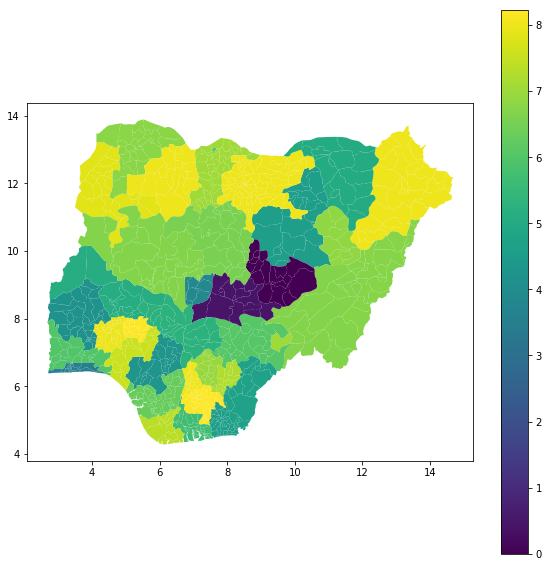

In [23]:
# creating a plot
# any white space is probably a null value, meaning either no data, or something is wrong the data cleaning I did
merged.plot(column='total requested / target population', legend=True, figsize=(10,10))

In [94]:
final_merged.to_csv('updated_data.csv')

C:\Users\Adi\Anaconda3\lib\site-packages\matplotlib\colors.py:937: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
C:\Users\Adi\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


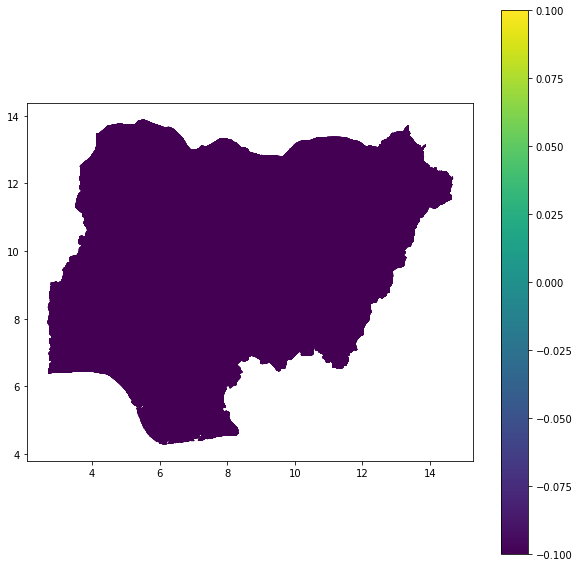

In [93]:
final_merged.plot(column=['lf_yld', 'alb_ratio'], legend=True, figsize=(10,10))

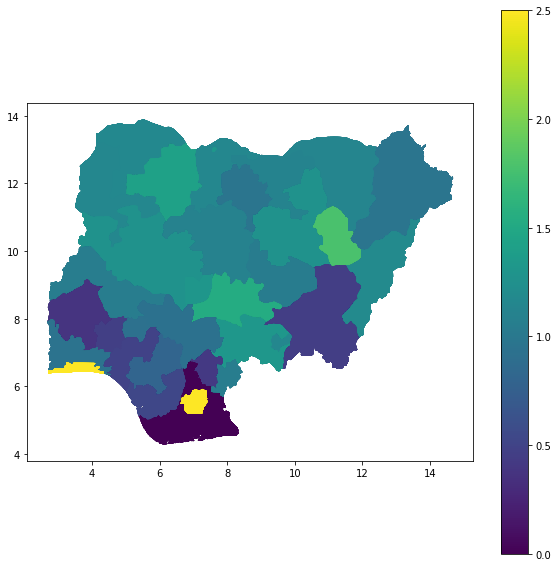

In [92]:
final_merged.plot(column='pzq_ratio', legend=True, figsize=(10,10))

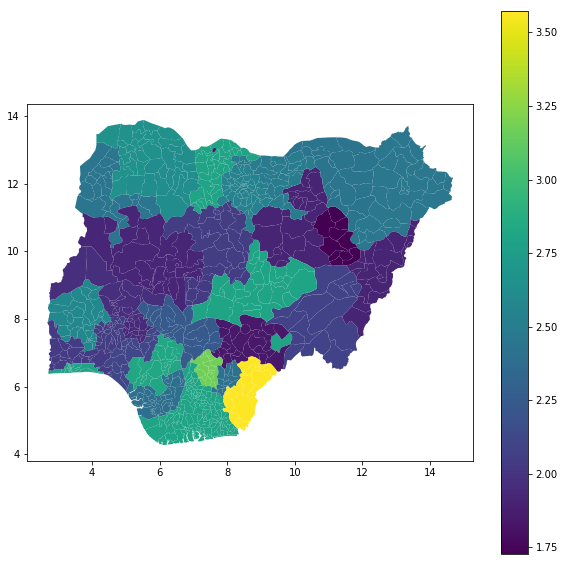

In [17]:
merged_pop.plot(column='ivm_ratio', legend=True, figsize=(10,10))